In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

2.7.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7401966202322916523
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6300696576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15770876028577201797
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import numpy as np
import pandas as pd

from math import ceil
from numba import njit, prange
from sklearn.utils.validation import check_array
from pyts.preprocessing import MinMaxScaler
from pyts.approximation import PiecewiseAggregateApproximation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import os 
import cv2

In [4]:
Welding_data = np.load('E:/Result/ver.3.22/MTF/MTF.npz')

X_data = Welding_data['X_data']
y_data = Welding_data['y_data']
i_data = Welding_data['i_data']

Welding_data.close()

In [5]:
seed = 7
np.random.seed()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test,i_train, i_test = train_test_split(X_data, y_data, i_data, test_size= 0.2, shuffle= True, random_state= seed)

In [6]:
inputs = np.concatenate((X_train, X_test))
targets = np.concatenate((y_train, y_test))
index = np.concatenate((i_train, i_test))

In [7]:
targets = np_utils.to_categorical(targets)

In [8]:
from keras.applications.efficientnet import EfficientNetB3
from keras.layers import Dense, Input, Activation, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization.batch_normalization import BatchNormalization

In [9]:
input = Input(shape= (300,300,2))
model = EfficientNetB3(
    input_tensor= input,
    include_top= False,
    weights= None,
    pooling= 'avg'
)

x = model.output
#x = Dropout(0,2)(x)
x = Dense(3, activation= 'softmax', name= 'softmax')(x)

model = Model(model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 2  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 2)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 2)  5           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 301, 301, 2)  0           ['normalization[0][0]']      

In [10]:
#tf.keras.utils.plot_model(model, show_shapes= True)

In [11]:
import keras.backend as K
import datetime

log_dir = "logs_EffiB3/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir, histogram_freq= 1)

In [12]:

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle= True, random_state= seed)

test= []
train= []
test_= []
train_= []

for train, test in kfold.split(inputs, targets):
    
    print(len(test))
    print(len(train))
    
    for i in zip(test):
        test_.append(i)
    for i in zip(train):
        train_.append(i)


118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
118
1061
117
1062


In [13]:
train = train_[0:1061]
train = np.reshape(train, 1061)
test = test_[0:117]
test = np.reshape(test, 117)

In [14]:
print(inputs.shape)
print(targets.shape)
print(index.shape)

(1179, 300, 300, 2)
(1179, 3)
(1179,)


In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

acc_per_fold = []
loss_per_fold = []

kfold = StratifiedKFold(n_splits=10, shuffle=True)

fold_no = 1

with tf.device('/gpu:0'):
    for train, test in kfold.split(X_train, y_train):
        print(train.shape, test.shape)
    
        input = Input(shape=(300, 300, 2))
        model = EfficientNetB3(input_tensor=input, include_top=False, weights=None, pooling='avg')
        
        x = model.output

        x = Dense(3, activation='softmax', name='softmax', kernel_initializer='he_normal')(x)
        model = Model(model.input, x)

        
        optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
        #optimizer = optimizers.Adam(lr=0.001)
        
        #callbacks_list = [LearningRateSchedule([20,40])]
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        history = model.fit(inputs[train], targets[train], 
                            batch_size=4, 
                            epochs=100, 
                            verbose=1,
                            validation_data=(inputs[test], targets[test]),
                            callbacks = tensorboard_callback) # 여기에 Validation set을 넣어야되는거 아닌가?
        
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
     

        #np.savetxt('E:/Result/ver.3.25/EfficientNetB1/acc/'+ f'acc_{i}.csv', acc_per_fold, delimiter=",")
        #np.savetxt('E:/Result/ver.3.25/EfficientNetB1/loss/'+ f'loss_{i}.csv', loss_per_fold, delimiter=",")
        
        model.save('E:/Result/ver.3.26/EfficientNetB3/' + f'Eff_{fold_no}.h5',fold_no)
        
        fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


(848,) (95,)


C:\Users\jwhyu\anaconda3\envs\venv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


------------------------------------------------------------------------
Training for fold 1 ...


C:\Users\jwhyu\anaconda3\envs\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
212/212 [==============================] - 48s 174ms/step - loss: 0.5956 - accuracy: 0.4776 - val_loss: 1.1965 - val_accuracy: 0.3474
Epoch 2/100
212/212 [==============================] - 34s 162ms/step - loss: 0.5231 - accuracy: 0.5743 - val_loss: 1.3695 - val_accuracy: 0.3474
Epoch 3/100
212/212 [==============================] - 34s 159ms/step - loss: 0.4833 - accuracy: 0.6238 - val_loss: 1.0550 - val_accuracy: 0.3474
Epoch 4/100
212/212 [==============================] - 34s 159ms/step - loss: 0.4457 - accuracy: 0.6710 - val_loss: 2.3959 - val_accuracy: 0.1895
Epoch 5/100
212/212 [==============================] - 34s 159ms/step - loss: 0.4470 - accuracy: 0.6851 - val_loss: 0.4055 - val_accuracy: 0.6842
Epoch 6/100
212/212 [==============================] - 34s 159ms/step - loss: 0.4129 - accuracy: 0.7064 - val_loss: 5.8599 - val_accuracy: 0.2105
Epoch 7/100
212/212 [==============================] - 34s 159ms/step - loss: 0.3895 - accuracy: 0.7252 - val_loss: 2.3008 -

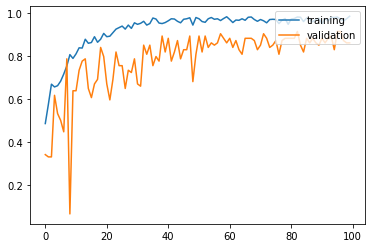

In [16]:
import matplotlib.pylab as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc= 'upper right')
plt.show()

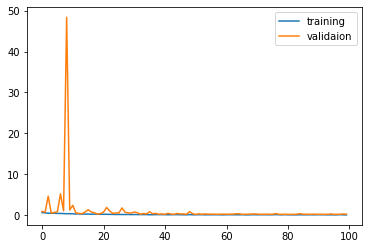

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validaion'], loc= 'upper right')
plt.show()\
    